In [1]:
import os
import random
import json
import cv2
import numpy as np
from math import sqrt
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn

In [2]:
CUDA_LAUNCH_BLOCKING=1
TORCH_USE_CUDA_DSA=1

### Load data

In [3]:
dataset_base_path = '/home/smbh/iirbctf/data/clevr/CLEVR_CoGenT_v1.0/'
x_train_img = []
for img in os.listdir(dataset_base_path + 'images/trainA'):
    x_train_img.append(img)
x_valid_img = []
for img in os.listdir(dataset_base_path + 'images/valA'):
    x_valid_img.append(img)
x_test_img = []
for img in os.listdir(dataset_base_path + 'images/testA'):
    x_test_img.append(img)

y_train_img = json.load(open(dataset_base_path + "scenes/CLEVR_trainA_scenes.json", "r"))['scenes']
y_valid_img = json.load(open(dataset_base_path + "scenes/CLEVR_valA_scenes.json", "r"))['scenes']


print('x_train_img: ', len(x_train_img))
print('x_valid_img: ', len(x_valid_img))
print('x_test_img: ', len(x_test_img))

print('y_train_img: ', len(y_train_img))
print('y_valid_img: ', len(y_valid_img))

x_train_img:  70000
x_valid_img:  15000
x_test_img:  15000
y_train_img:  70000
y_valid_img:  15000


In [4]:
x_train_txt = json.load(open(dataset_base_path + "/questions/CLEVR_trainA_questions.json", "r"))['questions']
x_valid_txt = json.load(open(dataset_base_path + "/questions/CLEVR_valA_questions.json", "r"))['questions']


print('x_train_txt: ', len(x_train_txt))
print('x_valid_txt: ', len(x_valid_txt))

x_train_txt:  699960
x_valid_txt:  150000


In [5]:
DATA_PROPORTION = 0.01
# DATA_PROPORTION = 1

x_train_img = x_train_img[:int(DATA_PROPORTION * len(x_train_img))]
x_valid_img = x_valid_img[:int(DATA_PROPORTION * len(x_valid_img))]
x_test_img = x_test_img[:int(DATA_PROPORTION * len(x_test_img))]

print('x_train_img: ', len(x_train_img))
print('x_valid_img: ', len(x_valid_img))
print('x_test_img: ', len(x_test_img))

x_train_img:  700
x_valid_img:  150
x_test_img:  150


In [6]:
if DATA_PROPORTION != 1:
    y_train_img = [y for y in y_train_img if y['image_filename'] in x_train_img]
    y_valid_img = [y for y in y_valid_img if y['image_filename'] in x_valid_img]

    x_train_txt = [x for x in x_train_txt if x['image_filename'] in x_train_img]
    x_valid_txt = [x for x in x_valid_txt if x['image_filename'] in x_valid_img]

print('y_train_img: ', len(y_train_img))
print('y_valid_img: ', len(y_valid_img))

print('x_train_txt: ', len(x_train_txt))
print('x_valid_txt: ', len(x_valid_txt))

y_train_img:  700
y_valid_img:  150
x_train_txt:  7000
x_valid_txt:  1500


(320, 480, 3)


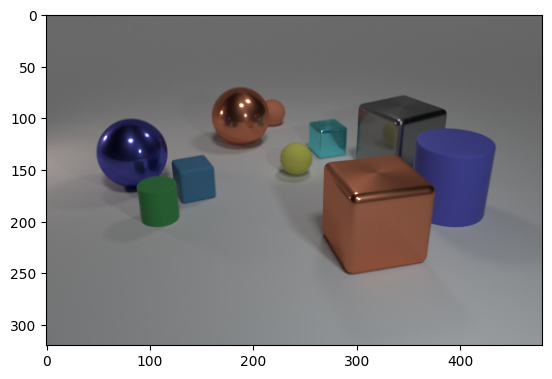

In [7]:
idx = random.randint(0, len(x_valid_img))
img = cv2.imread(dataset_base_path + 'images/valA/' + x_valid_img[idx])
INPUT_SHAPE = img.shape
print(INPUT_SHAPE)
plt.imshow(img)
plt.show()

In [8]:
x_train_txt[random.randint(0, len(x_train_img))]

{'question_index': 68899,
 'question_family_index': 7,
 'image_index': 6890,
 'question': 'Is the number of red metallic balls to the left of the red ball less than the number of tiny things that are behind the yellow metal block?',
 'answer': 'no',
 'image_filename': 'CLEVR_trainA_006890.png',
 'split': 'trainA',
 'program': [{'value_inputs': [], 'inputs': [], 'function': 'scene'},
  {'value_inputs': ['red'], 'inputs': [0], 'function': 'filter_color'},
  {'value_inputs': ['sphere'], 'inputs': [1], 'function': 'filter_shape'},
  {'value_inputs': [], 'inputs': [2], 'function': 'unique'},
  {'value_inputs': ['left'], 'inputs': [3], 'function': 'relate'},
  {'value_inputs': ['red'], 'inputs': [4], 'function': 'filter_color'},
  {'value_inputs': ['metal'], 'inputs': [5], 'function': 'filter_material'},
  {'value_inputs': ['sphere'], 'inputs': [6], 'function': 'filter_shape'},
  {'value_inputs': [], 'inputs': [7], 'function': 'count'},
  {'value_inputs': [], 'inputs': [], 'function': 'scene

In [9]:
print(y_valid_img[0].keys())
print("----" * 4)
print("Image filename: ", y_valid_img[0]['image_filename'])
print("Split: ", y_valid_img[0]['split'])
print("Image index: ", y_valid_img[0]['image_index'])
print("----" * 4)
print("Objects: ")
for k, v in y_valid_img[0]['objects'][0].items():
    print("\t", k, v)
print("----" * 4)
print("Relationships: ")
for k, v in y_valid_img[0]['relationships'].items():
    print("\t", k, v)
print("----" * 4)
print("Directions: ")
for k, v in y_valid_img[0]['directions'].items():
    print("\t", k, v)

dict_keys(['image_filename', 'objects', 'split', 'image_index', 'relationships', 'directions'])
----------------
Image filename:  CLEVR_valA_000248.png
Split:  valA
Image index:  248
----------------
Objects: 
	 pixel_coords [194, 140, 10.312368392944336]
	 size large
	 color blue
	 material metal
	 shape cube
	 3d_coords [-0.18231461942195892, -1.0461581945419312, 0.699999988079071]
	 rotation 128.5918662329013
----------------
Relationships: 
	 right [[2, 3, 6], [0, 2, 3, 4, 5, 6], [6], [2, 6], [0, 2, 3, 5, 6], [0, 2, 3, 6], []]
	 front [[3, 4, 5], [0, 3, 4, 5, 6], [0, 1, 3, 4, 5, 6], [], [3, 5], [3], [0, 3, 4, 5]]
	 left [[1, 4, 5], [], [0, 1, 3, 4, 5], [0, 1, 4, 5], [1], [1, 4], [0, 1, 2, 3, 4, 5]]
	 behind [[1, 2, 6], [2], [], [0, 1, 2, 4, 5, 6], [0, 1, 2, 6], [0, 1, 2, 4, 6], [1, 2]]
----------------
Directions: 
	 above [0.0, 0.0, 1.0]
	 right [0.6563112735748291, 0.7544902563095093, -0.0]
	 front [0.754490315914154, -0.6563112735748291, -0.0]
	 behind [-0.754490315914154, 0.656

### Process Data

In [10]:
vocab = {"<PAD>": 0}
x_train_questions = []
y_train_answers = []
x_valid_questions = []
y_valid_answers = []
MAX_LENGTH = 0


def vocab_counter(dataset, vocab, MAX_LENGTH):
    for q in dataset:
        _q = q["question"].replace("?", "").replace(".", "").replace(",", "").split(" ")
        x_train_questions.append(_q)
        y_train_answers.append(q["answer"])
        if len(_q) > MAX_LENGTH:
            MAX_LENGTH = len(_q)
        # question
        for w in _q:
            if w in vocab:
                vocab[w] += 1
            else:
                vocab[w] = 1
        # answer
        for w in q["answer"].split(" "):
            if w in vocab:
                vocab[w] += 1
            else:
                vocab[w] = 1
        # inputs
        for p in q["program"]:
            for _iv in p["value_inputs"]:
                if _iv in vocab:
                    vocab[_iv] += 1
                else:
                    vocab[_iv] = 1
            # functions
            for w in p["function"].split("_"):
                if w in vocab:
                    vocab[w] += 1
                else:
                    vocab[w] = 1
    return vocab, MAX_LENGTH

vocab, MAX_LENGTH = vocab_counter(x_train_txt, vocab, MAX_LENGTH)
vocab, MAX_LENGTH = vocab_counter(x_valid_txt, vocab, MAX_LENGTH)

vocab = list(set(vocab))
vocab.remove("")
len(vocab)

117

In [11]:
# convert the input sentences to a tensor of indices
def encode_sentence(sentence, vocab, MAX_LENGTH):
    sentence = sentence.replace("?", "").replace(".", "").replace(",", "").split(" ")
    sentence = [w for w in sentence if w != ""]
    sentence = sentence + ["<PAD>"] * (MAX_LENGTH - len(sentence))
    encoded = []
    for w in sentence:
        encoded.append(vocab.index(w))
    return encoded

def encode_answer(answer, vocab):
    encoded = []
    for w in answer.split(" "):
        encoded.append(vocab.index(w))
    return encoded

y_train_txt = [encode_answer(q["answer"], vocab) for q in x_train_txt]
y_valid_txt = [encode_answer(q["answer"], vocab) for q in x_valid_txt]

x_train_txt = [encode_sentence(q["question"], vocab, MAX_LENGTH) for q in x_train_txt]
x_valid_txt = [encode_sentence(q["question"], vocab, MAX_LENGTH) for q in x_valid_txt]


print("x_train_txt: ", len(x_train_txt))
print("y_train_txt: ", len(y_train_txt))

print("x_valid_txt: ", len(x_valid_txt))
print("y_valid_txt: ", len(y_valid_txt))

x_train_txt:  7000
y_train_txt:  7000
x_valid_txt:  1500
y_valid_txt:  1500


### Test Model

In [12]:
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')

In [13]:
class Attention(nn.Module):
    def __init__(self, feature_dim):
        super(Attention, self).__init__()

        self.query_layer = nn.Linear(feature_dim, feature_dim)
        self.key_layer = nn.Linear(feature_dim, feature_dim)
        self.value_layer = nn.Linear(feature_dim, feature_dim)
        
        self.sqrt_dv = np.sqrt(feature_dim)

    def forward(self, V):
        Q = self.query_layer(V)
        K = self.key_layer(V)
        V = self.value_layer(V)

        # permute dimensions for matrix multiplication
        Q = Q.permute(0, 2, 1)
        K = K.permute(0, 2, 1)
        V = V.permute(0, 2, 1)
        
        attention_weights = F.softmax(Q @ K / self.sqrt_dv, dim=-1)

        # add identity matrix
        attention_weights += torch.eye(V.size(1)).to(V.device)
        
        # V = attention_weights @ V
        V = attention_weights @ V.permute(0, 2, 1)  # [batch_size, seq_length, feature_dim]

        return V

#### Faster RCNN

In [14]:
# Initialize a pre-trained Faster R-CNN model
# /home/smbh/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
model = fasterrcnn_resnet50_fpn(pretrained=True)
# Ensure the model is in evaluation mode
model.eval()
model.to(device)

/home/smbh/.venvs/iirbctf/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/smbh/.venvs/iirbctf/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [15]:
visual_attention = Attention(feature_dim=256).to(device)

# put the model in evaluation mode and move to the appropriate device
visual_attention.eval()
visual_attention.to(device)

Attention(
  (query_layer): Linear(in_features=256, out_features=256, bias=True)
  (key_layer): Linear(in_features=256, out_features=256, bias=True)
  (value_layer): Linear(in_features=256, out_features=256, bias=True)
)

In [16]:
# Assume your input image is a PyTorch tensor with shape [3, H, W]
# for RGB channels and height/width dimensions respectively.
# Make sure your image is normalized (values between 0 and 1) and
# is of the correct input size for the model.
input_image = cv2.imread(dataset_base_path + 'images/valA/' + x_valid_img[idx])
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB).astype(np.float32)
input_image = cv2.resize(input_image, (224, 224))
input_image = input_image / 255.0
input_image = input_image.transpose((2, 0, 1))

# Add an extra batch dimension
input_image = torch.unsqueeze(torch.from_numpy(input_image), 0)
input_image = input_image.to(device)
print(input_image.shape)

torch.Size([1, 3, 224, 224])


In [17]:
# The model returns a list of dictionaries for each image in the batch
# (even if there's just one). Each dict contains the bounding boxes 
# ("boxes"), labels ("labels"), and scores ("scores") for each detected object.
with torch.no_grad():
    output = model(input_image)

    # Extract the feature maps from the backbone of the Faster R-CNN
    # which will be your image region feature V. 
    # The features are a tensor of shape [N, C, H, W] where N is the number
    # of images (1 in this case), C is the number of channels, and H and W are 
    # the height and width of the feature map respectively.

    # odict_keys(['0', '1', '2', '3', 'pool'])
    v_feature = model.backbone(input_image)['0']
    # Apply visual attention
    # v_feature = v_feature.to(device)
    print(v_feature.shape)
    v_feature_att = visual_attention(v_feature)

# Extract the bounding boxes and scores
boxes = output[0]['boxes']
scores = output[0]['scores']

# Filter out detections with a score below some threshold, if necessary
threshold = 0.5
indices = scores > threshold
boxes = boxes[indices]

# The bounding boxes are in the format [x0, y0, x1, y1], where (x0, y0)
# is the top-left corner of the box and (x1, y1) is the bottom-right.
# convert these to a spatial coordinate feature C as needed.

v_feature.shape, v_feature_att.shape

torch.Size([1, 256, 56, 56])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (14336x56 and 256x256)

In [ ]:
# Assume 'boxes' contains the bounding box coordinates extracted from Faster R-CNN
# and 'input_image' is original input image

# Get the height and width of the image
_, _, height, width = input_image.shape

# Normalize the bounding box coordinates
boxes_normalized = boxes / torch.tensor([width, height, width, height])

# Compute the width and height of each box
boxes_width_height = boxes_normalized[:, 2:] - boxes_normalized[:, :2]

# Concatenate the normalized coordinates and the widths/heights to form the spatial features
c_feature = torch.cat([boxes_normalized, boxes_width_height], dim=1)
c_feature.shape


torch.Size([2, 6])

#### Bi-directional GRU

In [ ]:
class TextEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, pad_idx):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.gru = nn.GRU(embed_dim, hidden_dim, num_layers, bidirectional=True, batch_first=True)
        self.hidden_dim = hidden_dim  # Storing hidden_dim for later use
        
    def forward(self, texts):
        embedded = self.embedding(texts)
        outputs, hidden = self.gru(embedded)

        # Since the GRU is bidirectional, the hidden states from the two directions are stacked on top of each other.
        # We need to add them together to get a single hidden state for each time step.
        outputs = outputs[:, :, :self.hidden_dim] + outputs[:, :, self.hidden_dim:]

        return outputs

In [ ]:
# Instantiate the TextEmbedding model
vocab_size = len(vocab)  # Your actual vocabulary size
embed_dim = 300  # Embedding dimension as per the paper
hidden_dim = 256  # This is a parameter that you can tune
num_layers = 1  # This is also a tunable parameter
pad_idx = vocab.index("<PAD>")  # Get the index of the padding token

model = TextEmbedding(vocab_size, embed_dim, hidden_dim, num_layers, pad_idx)

# Now, let's test the model with some an input from data
example_input = torch.tensor(x_valid_txt[0]).unsqueeze(0)  # Unsqueeze to add batch dimension
output = model(example_input)

print(output.shape)  # Expected: [batch_size, sequence_length, hidden_dim]

# Instantiate the Attention module
feature_dim = 256  # The dimension of your features
attention_model = Attention(feature_dim)

# Pass the example features through the Attention module
output = attention_model(output)

print(output.shape)  # Expected: [batch_size, sequence_length, feature_dim]

torch.Size([1, 39, 256])


RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [1, 39] but got: [1, 256].

### Data loader

In [ ]:
# get bounding box
def get_bbox(obj):
    sizes = {
        "large": 0.7,
        "small": 0.35
    }
    bbox = []
    if obj['shape'] == 'sphere':
        bbox = [
                obj['pixel_coords'][0] - (sizes[obj['size']] / obj['pixel_coords'][2]) * 600, 
                obj['pixel_coords'][1] - (sizes[obj['size']] / obj['pixel_coords'][2]) * 600, 
                (sizes[obj['size']] / obj['pixel_coords'][2]) * 600 * 2
                , (sizes[obj['size']] / obj['pixel_coords'][2]) * 600 * 2]
    elif obj['shape'] == 'cylinder':
        bbox = [
                obj['pixel_coords'][0] - (sizes[obj['size']] / obj['pixel_coords'][2]) * 600, 
                obj['pixel_coords'][1] - (sizes[obj['size']] / obj['pixel_coords'][2]) * 750, 
                (sizes[obj['size']] / obj['pixel_coords'][2]) * 600 * 2
                , (sizes[obj['size']] / obj['pixel_coords'][2]) * 750 * 2]
    else:
        bbox = [
                obj['pixel_coords'][0] - (sizes[obj['size']] / obj['pixel_coords'][2]) * 800, 
                obj['pixel_coords'][1] - (sizes[obj['size']] / obj['pixel_coords'][2]) * 800, 
                (sizes[obj['size']] / obj['pixel_coords'][2]) * 800 * 2
                , (sizes[obj['size']] / obj['pixel_coords'][2]) * 800 * 2]
    return bbox

In [ ]:
# Extract data from a scene
def scene_extractor(scene):
    """
    Extracts the following information from a scene:
        - image_filename
        - objects
        - split
        - image_index
        - relationships
        - directions
    """
    # add bounding boxes to objects
    for obj in scene['objects']:
        obj['bbox'] = get_bbox(obj)
    return {
        'image_filename': scene['image_filename'],
        'objects': scene['objects'],
        'split': scene['split'],
        'image_index': scene['image_index'],
        'relationships': scene['relationships'],
        'directions': scene['directions']
    }

In [ ]:
class CLEVRDataset(torch.utils.data.Dataset):
    def __init__(self, x, y, height, width,transforms=None):
        self.transforms = transforms
        self.x = x
        self.y = y
        self.height = height
        self.width = width
    
        self.x.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))
        # sort y to match x
        self.y.sort(key=lambda y: y['image_index'])

        # classes: 0 index is reserved for background
        # self.classes = ['background', 'cube', 'sphere', 'cylinder']
        self.classes = ['cube', 'sphere', 'cylinder']

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        if "val" in self.x[idx]:
            img = cv2.imread(dataset_base_path + 'images/valA/' + self.x[idx])
        else:
            img = cv2.imread(dataset_base_path + 'images/trainA/' + self.x[idx])

        org_shape = img.shape
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img = cv2.resize(img, (self.width, self.height), cv2.INTER_AREA)
        img = img / 255.0

        x_scale = self.width / org_shape[1]
        y_scale = self.height / org_shape[0]

        scene = scene_extractor(self.y[idx])
        boxes = []
        labels = []
        for obj in scene['objects']:
            labels.append(self.classes.index(obj['shape']))
            # boxes.append(obj['bbox'])
            this_bbox = obj['bbox']
            # sync bbox with resized image
            x_min = this_bbox[0] * x_scale
            y_min = this_bbox[1] * y_scale
            x_max = (this_bbox[0] + this_bbox[2]) * x_scale
            y_max = (this_bbox[1] + this_bbox[3]) * y_scale
            boxes.append([x_min, y_min, x_max, y_max])

            # # normalize to 0-1
            # bboxes = [x_min / self.width, y_min / self.height, x_max / self.width, y_max / self.height]
            # # < 0 to 0 and > 1 to 1
            # bboxes = [0 if b < 0 else b for b in bboxes]
            # bboxes = [1 if b > 1 else b for b in bboxes]
            # boxes.append(bboxes)

        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # getting the areas of the boxes
        areas = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = areas
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id

        if self.transforms:
            sample = self.transforms(image = img,
                            bboxes = target['boxes'],
                            labels = labels)
            img = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
        img = img.transpose(2, 0, 1)
        return img, target

In [ ]:
# plot bounding boxes
def plot_bbox(img, target):
    img = img.transpose(1, 2, 0)
    classes = ['cube', 'sphere', 'cylinder']
    for i in range(len(target['boxes'])):        
        plt.gcf().gca().add_artist(plt.Rectangle(
            (target['boxes'][i][0], target['boxes'][i][1]), 
            target['boxes'][i][2] - target['boxes'][i][0], 
            target['boxes'][i][3] - target['boxes'][i][1], 
            color='red', fill=False)
        )
        plt.text(target['boxes'][i][0], target['boxes'][i][1], classes[target['labels'][i]], color='white')
    plt.imshow(img)

In [ ]:
# use dataset and defined transformations
# dataset = CLEVRDataset(x_train, y_train, 224, 224, transforms=get_transform(train=True))
# dataset_valid = CLEVRDataset(x_val, y_val, 224, 224, transforms=get_transform(train=False))
dataset_train_img = CLEVRDataset(x_train_img, y_train_img, 224, 224)
dataset_valid_img = CLEVRDataset(x_valid_img, y_valid_img, 224, 224)
dataset_valid_img

(3, 224, 224)
{'boxes': tensor([[ 69.0634,  45.4950,  99.8700,  91.7050],
        [131.5550,  73.4325, 147.5117,  97.3675],
        [ 76.2885,  82.2327, 116.9115, 143.1673],
        [116.4668,  81.1752, 133.6665, 113.4248],
        [173.9895,  74.0842, 212.4105, 131.7158],
        [104.4873,  53.9886, 118.5794,  80.4114]]), 'labels': tensor([1, 1, 1, 2, 1, 2]), 'area': tensor([1423.5720,  381.9257, 2475.3538,  554.6852, 2214.2690,  372.3538]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0]), 'image_id': tensor([17])}


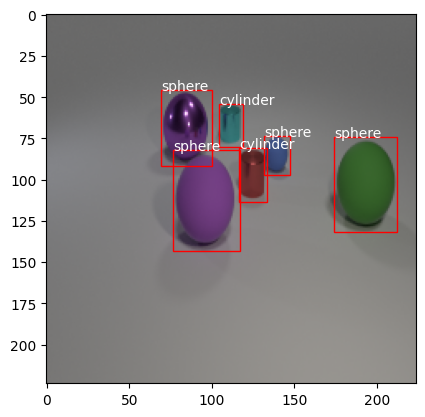

In [ ]:
img, target = dataset_valid_img[random.randint(0, len(y_valid_img))]
print(img.shape)
print(target)
plot_bbox(img, target)

In [ ]:
num_classes = len(dataset_valid_img.classes)
num_classes

3

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset_train_img, batch_size=10, shuffle=True, num_workers=4,
    collate_fn=collate_fn)

data_loader_valid = torch.utils.data.DataLoader(
    dataset_valid_img, batch_size=10, shuffle=False, num_workers=4,
    collate_fn=collate_fn)
data_loader_valid